<a href="https://colab.research.google.com/github/naoya1110/nitkc-ncku-ai-robotics/blob/main/Week05_Cats_vs_Dogs_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

From this week, we will be working on an image classification competition of cats vs dogs. Our goal is to implement an deep neural network model that can distinguish cats and dogs.

**GPU**

Please make sure your runtime type is GPU (cuda).

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


**General Packages**

Let's import some general Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os

# Data Preparation

Not like CIFAR10 dataset, the image data that will be provided here are in normal JPEG format. Therefore first we have to prepare dataset so that PyTorch can handle them. This is actually very important skill to conduct your own AI projects. 

Cats and dogs image data can be downloaded with the code below. Once the downloading is completed you will see `cats_vs_dogs_dataset.zip` in the Files tab on the left side.

In [3]:
os.system("curl gdrive.sh | bash -s https://drive.google.com/file/d/1WY8xxCmDn7z3u3-Edov0msZvY7x-tWmL/view?usp=sharing")

0

Then extract the zip file and you will see `cats_vs_dogs_dataset` directory in the Files tab.

In [4]:
os.system("unzip /content/cats_vs_dogs_dataset.zip")

0

There are directories named `train` and `test` under the `cats_vs_dogs_dataset` directory. In the `train` directory, there are sub directories of `cat` and `dog` which contain cats and dogs images, respectively. In the `test` directory, there is `unknown` sub directory that contains cats and dogs images together in random order.

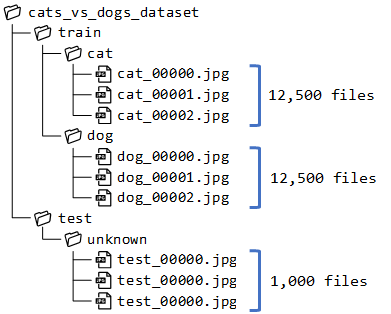

Let's check the number of files in the sub directories.

In [5]:
train_cat_dir = "cats_vs_dogs_dataset/train/cat"
train_dog_dir = "cats_vs_dogs_dataset/train/dog"
test_unknown_dir = "cats_vs_dogs_dataset/test/unknown"

print(train_cat_dir, len(os.listdir(train_cat_dir)))
print(train_dog_dir, len(os.listdir(train_dog_dir)))
print(test_unknown_dir, len(os.listdir(test_unknown_dir)))

cats_vs_dogs_dataset/train/cat 12500
cats_vs_dogs_dataset/train/dog 12500
cats_vs_dogs_dataset/test/unknown 1000


We can use `torchvision.datasets.ImageFoloder` for creating datasets with such directories tree structure.

In [6]:
from torchvision.datasets import ImageFolder

xy_train = ImageFolder(root="cats_vs_dogs_dataset/train")
xy_test = ImageFolder(root="cats_vs_dogs_dataset/test")

print(len(xy_train))
print(len(xy_test))

25000
1000


Let's see first 10 data in `xy_train` dataset.

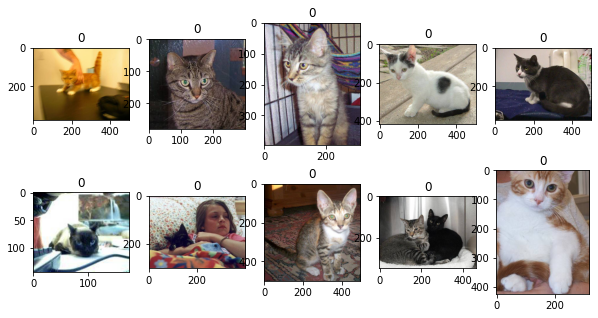

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = xy_train[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(label) 

Let's see 10 pictures from index of 12500 in `xy_train` dataset.

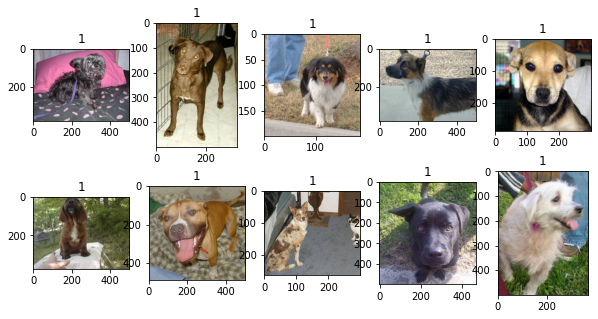

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = xy_train[i+12500]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(label) 

As you see above, cat images are labeled as "0" and dog images are labeled as "1". This is automatically done according to the sub directories in the `root` directory specified in `ImageFolder`. Here we define `classnames` dictionary for training data.

In [9]:
classnames = {0:"cat", 1:"dog"}

Let's see first 10 images in `xy_test` dataset. Since there is only one sub directory named `unknow`  in `test` directory, all images are labeled as "0" regardless of either cat or dog.

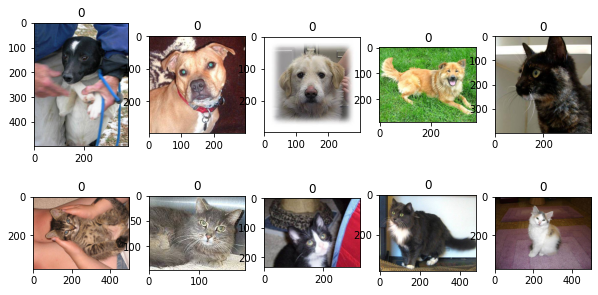

In [10]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = xy_test[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(label) 

We already learned that all the image data must be in the same shape for feeding the data to a PyTorch model . Here we resize all of the image data to 128x128 pixels. Also we convert the image data to `torch.tensor` format.

In [14]:
from torchvision import transforms

xy_train = ImageFolder(root="cats_vs_dogs_dataset/train",
                       transform=transforms.Compose([
                                 transforms.Resize((128, 128)),
                                 transforms.ToTensor()
                                 ])
                       )

xy_test = ImageFolder(root="cats_vs_dogs_dataset/test",
                      transform=transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.ToTensor()
                                ])
                      )

Since all of the test data are labeled as "0", we cannot use them for evaluating the model during the training process. Therefore we have to prepare another data for the evaluation. Such data are called validation data and usually taken from a part of training data. Here we divide xy_train to xy_valid and new xy_train.

In [15]:
import torch

n_samples = len(xy_train)
train_size = int(n_samples * 0.8)    # 80% will be training data
valid_size = n_samples - train_size  # 20% will be validation data

xy_train, xy_valid = torch.utils.data.random_split(xy_train, [train_size, valid_size])

print(len(xy_train))
print(len(xy_valid))

20000
5000


Then we create dataloader for training, validation and test data.

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(xy_train, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(xy_valid, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(xy_test, batch_size=32, shuffle=False, num_workers=2)

# Model Building

**Model Architecture**

You can build any kind of models you want, but now we just build the same model we used for CIFAR10.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128*32*32, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),    # add a dropout layer
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model().to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)


Let's see the model archtecture. Note that since the input image shape is different from CIFAR10 dataset, the output shape of the features part is also different. Thus we have to change the input shape of the classifier part as well.

In [18]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([32, 3, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [32, 128, 32, 32]         --
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        1,792
│    └─ReLU: 2-2                         [32, 64, 128, 128]        --
│    └─MaxPool2d: 2-3                    [32, 64, 64, 64]          --
│    └─Conv2d: 2-4                       [32, 128, 64, 64]         73,856
│    └─ReLU: 2-5                         [32, 128, 64, 64]         --
│    └─MaxPool2d: 2-6                    [32, 128, 32, 32]         --
├─Sequential: 1-2                        [32, 2]                   --
│    └─Linear: 2-7                       [32, 256]                 33,554,688
│    └─ReLU: 2-8                         [32, 256]                 --
│    └─Dropout: 2-9                      [32, 256]                 --
│    └─Linear: 2-10                      [32, 2]                   514

# Training

**Loss Function**


In [19]:
loss_func = nn.CrossEntropyLoss()

**Optimizer**


In [20]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

**Training Loop**







In [21]:
epochs = 10
best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_accuracy = 0
    train_loss = 0
    valid_accuracy = 0
    valid_loss = 0

    model.train()          # set model to training mode

    for x_batch, y_batch in tqdm(train_loader):      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
        
        optimizer.zero_grad()                  # reset gradients to 0
        y_pred = model(x_batch)                # do prediction
        loss = loss_func(y_pred, y_batch)        # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                           # accumulate loss value
        y_pred_label = torch.argmax(y_pred, dim=1)          # 
        train_accuracy += (y_pred_label == y_batch).sum()   # count up number of correct predictions

    with torch.no_grad():     # disable autograd for saving memory usage
        model.eval()          # set model to evaluation mode

        for x_batch, y_batch in tqdm(valid_loader):   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            y_pred = model(x_batch)            # do prediction
            loss = loss_func(y_pred, y_batch)    # measure loss

            valid_loss += loss.item()                          # accumulate loss value
            y_pred_label = torch.argmax(y_pred, dim=1)        # convert y_pred vector to target class index
            valid_accuracy += (y_pred_label == y_batch).sum()  # count up number of correct predictions

            # save the model if the accuracy is better than before
            if valid_accuracy > best_accuracy:
                torch.save(model.state_dict(), best_model_path)
                best_accuracy = valid_accuracy

    train_accuracy = train_accuracy/len(xy_train)   # determine accuracy for training data
    valid_accuracy = valid_accuracy/len(xy_valid)      # determin accuracy for test data
    train_loss = train_loss/len(train_loader)           # determin loss for training data
    valid_loss = valid_loss/len(valid_loader)              # determin loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}\n")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)

Epoch 1/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.502 Loss=0.712, Valid: Accuracy=0.500 Loss=0.693

Epoch 2/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.562 Loss=0.684, Valid: Accuracy=0.593 Loss=0.670

Epoch 3/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.605 Loss=0.662, Valid: Accuracy=0.663 Loss=0.621

Epoch 4/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.680 Loss=0.597, Valid: Accuracy=0.713 Loss=0.568

Epoch 5/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.729 Loss=0.534, Valid: Accuracy=0.724 Loss=0.554

Epoch 6/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.769 Loss=0.486, Valid: Accuracy=0.713 Loss=0.561

Epoch 7/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.802 Loss=0.424, Valid: Accuracy=0.726 Loss=0.571

Epoch 8/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.850 Loss=0.344, Valid: Accuracy=0.732 Loss=0.594

Epoch 9/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.890 Loss=0.263, Valid: Accuracy=0.729 Loss=0.683

Epoch 10/10


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train: Accuracy=0.923 Loss=0.196, Valid: Accuracy=0.738 Loss=0.745



**Learning Curves**

Let's visualize the accuracy and the loss curves for training and validation data.

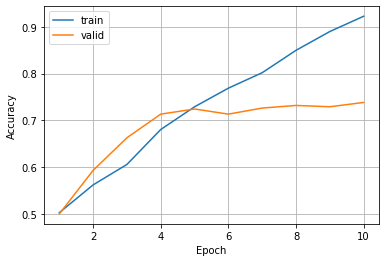

In [22]:
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, valid_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

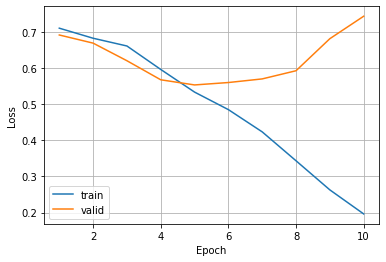

In [23]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Evaluation

**Load the Best Model**

In [24]:
model = Model().to(device)
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

**Predictions for Test Data**

Let's see predictions for some test data.

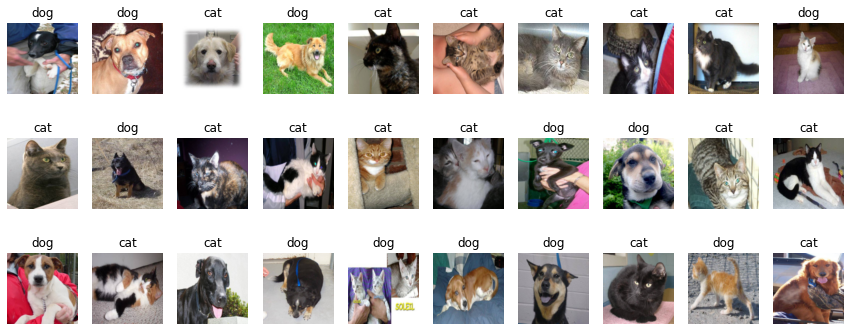

In [ ]:
with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        y_pred_label = torch.argmax(y_pred, dim=1)

        plt.figure(figsize=(15, 6))
        for i in range(30):
            image = x_batch[i].to("cpu").numpy()
            image = np.transpose(image, (1,2,0))
            plt.subplot(3, 10, i+1)
            plt.imshow(image)

            pred_class = classnames[y_pred_label[i].item()]
            plt.title(pred_class)
            plt.axis("off")
        
        break

# Submission

Now we make predictions for all the test data.

In [ ]:
y_pred_label_all = []

with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        y_pred_label = torch.argmax(y_pred, dim=1)
        y_pred_label_all = np.append(y_pred_label_all, y_pred_label.to("cpu").numpy())

y_pred_label_all = y_pred_label_all.astype("uint8")
print(y_pred_label_all)

[1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0
 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 1
 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0
 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1
 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1
 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0
 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1
 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0
 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0
 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 0 

Please set your username here.

In [ ]:
username = "naoya"

Now we create a submission file named `{username}_submission.csv`.

In [ ]:
df_submit = pd.DataFrame()
df_submit["id"] = np.arange(1000)
df_submit["label"] = y_pred_label_all

df_submit.to_csv(f"{username}_submission.csv", index = False)

df_submit

,id,label
0,0,1
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
995,995,0
996,996,1
997,997,0
998,998,0


**Submission Form**

Now you can find your submission file `{username}_submission.csv` in the Files tab. Please download it to your local storage and submit it from the submission form below.

https://forms.gle/BfcbrAqBCYicCSzt9

**Leaderboard**

You can check your score and standing.

https://drive.google.com/file/d/1a8f0EKU3POHCpOR6wfocHk27FWpEn6nx/view?usp=sharing

In [ ]:
os.system("curl gdrive.sh | bash -s https://drive.google.com/file/d/1a8f0EKU3POHCpOR6wfocHk27FWpEn6nx/view?usp=sharing")
df_ranking = pd.read_csv("/content/cats_vs_dogs_ranking.csv")
os.remove("/content/cats_vs_dogs_ranking.csv")

df_ranking.head(100)

,Rank,Username,Accuracy,Submission Time (UTC)
0,1,iwamoto_test,0.771,2021-08-20 13:13:36
1,2,naoya,0.743,2021-08-21 02:21:47
2,3,iwamoto,0.723,2021-08-20 05:08:27
3,4,naoya_pytorch,0.723,2021-08-20 04:53:29


# Conclusion

That's it for this week. Now you can try to increase the test accuracy by changing data augmentation methods, model architecture, training epochs and so on...